<a href="https://colab.research.google.com/github/tiaaburton/2021-Visualization-Projects/blob/main/notebooks/a1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install pyspark --quiet
! pip install plotly --quiet
! pip install chart_studio --quiet
! pip install mlflow --quiet
! pip install spark_sklearn --quiet

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 58.1 MB/s 
     |████████████████████████████████| 64 kB 1.9 MB/s 
     |████████████████████████████████| 17.8 MB 4.3 MB/s 
     |████████████████████████████████| 181 kB 60.8 MB/s 
     |████████████████████████████████| 210 kB 65.2 MB/s 
     |████████████████████████████████| 79 kB 10.4 MB/s 
     |████████████████████████████████| 596 kB 53.6 MB/s 
     |████████████████████████████████| 146 kB 73.7 MB/s 
     |████████████████████████████████| 62 kB 886 kB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 4.9 MB 6.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires 

In [4]:
# !pip install -r requirements.txt

In [5]:
import pandas as pd
import numpy as np
import re
import os
import sys
import ast
import json
import random
import pyarrow
import sklearn
import time

from google.cloud import bigquery
# from oauth2client.client import GoogleCredentials
from google.colab import auth, files
from datetime import datetime
from tqdm import tqdm
from typing import Union
from spark_sklearn import Converter

import pyspark
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml import *
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SQLContext
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, roc_auc_score

import chart_studio.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
/usr/

In [6]:
RANDOM_SEED = 655

In [7]:
def pyspark_column_prep(dataset):
  """Returns column names with underscores instead of periods to use easily with pyspark.
     dataset: pd.DataFrame"""
  for col in dataset.columns:
    if '.' in col:
      repl = col.replace('.','_')
      dataset.rename(columns={col: repl},inplace=True)

  return dataset

In [8]:
a1_b2_dataset = pd.read_csv(
    '/content/drive/Shareddrives/SIADS - 694-695 Team Drive/datasets/model_files/A1_B2_data.csv'
    )

spark_ready_X = pyspark_column_prep(a1_b2_dataset)

In [9]:
# a1_b2_dataset.columns

In [10]:
train = spark_ready_X[spark_ready_X.columns[~spark_ready_X.columns.isin([
                                                                         'Monetary',
                                                                         'buyers',
                                                                         'Frequency',
                                                                         'repurchasers',
                                                                         'Recency',
                                                                         'socialEngagementType',
                                                                         'total_transactions'
                                                                         ])]]
target = a1_b2_dataset[['totals_transactions']]
target = target.totals_transactions.fillna(0.0).apply(lambda trans: trans if trans == 0.0 else 1.0)
target = pd.Categorical(target)
target = pd.Series(target)


In [11]:
target.nunique()

2

### Visualizations and Assumption Validation

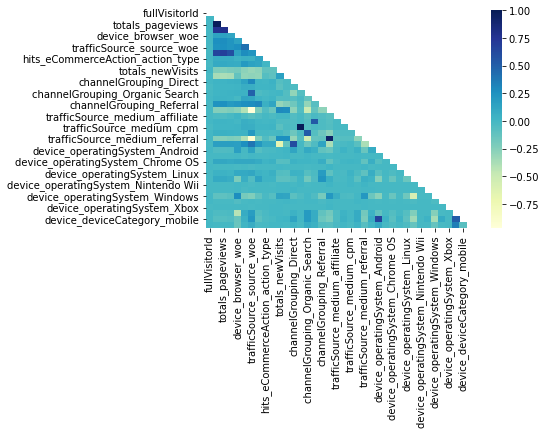

In [12]:
mask = np.triu(np.ones_like(train.corr()))
dataplot = sns.heatmap(train.corr(), cmap="YlGnBu", annot=False, mask=mask)
plt.show() # need to increase the size of the image that I have in this chargt

## PySpark Models

1. Create a spark session
2. If you have not exited the last Spark session, it will remain open. To forcible start a new session, with new environment variables, run the newSession() method.
3.Change the s

In [13]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Binary Buyer Prediction") \
    .getOrCreate()

In [14]:
spark.newSession()

In [15]:
train_spark = (spark.createDataFrame(a1_b2_dataset)
                    .withColumnRenamed('totals_transactions','label')
                    .withColumn('day', dayofmonth('date'))
                    .withColumn('year', year('date'))
                    .withColumn('month', month('date'))
                    .withColumn('week_day', dayofweek('date'))
                    .drop('date','socialEngagementType','buyers',
                          'Monetary','Frequency', 'repurchasers'))

### Methodology:
Transformations:
- PCA: since there was high correlation seen between a number of the measures, I decided that testing the models with less features, while all the same being equally representative of the variance of the data, would be work trying to understand the results various results.
- Date transformations (day of month, month, week number, year): could be some seasonal patterns that are captured by the model such as holidays or around the end of summer when new grads / hires are going Google or its subsidaries.
- Under / order sampling: 
  - Under sampling - using the same number of customers / visits labels
  - Over (up) sampling - creating duplicates or other examples to provide the dataset with more examples to be able the same number as the other class
- Train, (val), test: The dataset will be split with a .75 / .25 data split to mimic the sklearn train validation split. The training dataset will be used with benchmark models and 

*Ethical consideration*: continued to exclude fullvisitorid because it was not useful for understanding if a customer was likely to return or not.


In [16]:
def downsampling(data):
  df = data.withColumn('rand_col', rand())
  balanced_data = df.withColumn("row_num",row_number().over(Window.partitionBy("label")\
                                                         .orderBy("rand_col"))).filter(col("row_num")<=label_balance.head(2)[1][1])\
                                                         .drop("rand_col", "row_num")
  return balanced_data

def upsampling(data):
  visitors = data.filter(col('label') == 0)
  customers = data.filter(col('label') == 1)
  newCustomers = customers.alias('newCustomers')

  while newCustomers.count() < visitors.count():
    newCustomers = newCustomers.unionByName(customers, allowMissingColumns=False)

  balanced_data = newCustomers.unionByName(visitors)
  return balanced_data

def take_random_sample(data):
  return data.sample(True, .1, RANDOM_SEED)

In [17]:
unbalanced_df = train_spark.withColumn('label', when(col('label')==0.0, 0).otherwise(1.0))
label_balance = unbalanced_df.select('label','year').groupBy('label').count()

utrain_df = upsampling(unbalanced_df)
dtrain_df = downsampling(unbalanced_df)
random_df = take_random_sample(unbalanced_df)

utdf = utrain_df.select('label').groupBy('label').count().withColumnRenamed('count','upsampling_count')
dtdf = dtrain_df.select('label').groupBy('label').count().withColumnRenamed('count','downsampling_count')
rdf = random_df.select('label').groupBy('label').count().withColumnRenamed('count','randsamp_count')

(label_balance.join(utdf,how='inner',on='label')
            .join(dtdf,how='inner',on='label')
            .join(rdf,how='inner',on='label')).show()

+-----+-----+----------------+------------------+--------------+
|label|count|upsampling_count|downsampling_count|randsamp_count|
+-----+-----+----------------+------------------+--------------+
|  1.0| 5865|           52785|              5865|           600|
|  0.0|49516|           49516|              5865|          4828|
+-----+-----+----------------+------------------+--------------+



### T-Test: is the random sample of the same distribution as the first random sample

Models:
- Logistic Regression (baseline model since pyspark doesn't have a dummy classifier)
- SVC (recommended by imbalanced classes - a gentle intro...source?)
- Decision Tree (more robust model)
- Random Forest Classifier (most robust model for classification)

Models not tested:
Conditional probability as given by the Bayes Theorem. Some theory: https://www.youtube.com/watch?v=l3dZ6ZNFjo0.

* Naive Bayes: PySpark implementation of the Naive Bayes model has a bernoulli variable that would be able to help predict the true and false values, but there are many articles that suggest this technique is best used for textual analysis, which we are not doing at this time. Another barrier of this model is the assumptions that all the features are independent, and this is not the case as we derived many of the features  


Metrics:
 - LogLoss (MulticlassMetrics): could be utilized for the

 Tracking will be discussed later after all metrics are recorded into MLFlow with DAGsHub. This will be connected to the repository found on GitHub as well.

In [18]:
X_train_balanced, X_test_balanced = unbalanced_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)
X_train_upsample, X_test_upsample = utrain_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)
X_train_dsample, X_test_dsample = dtrain_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)
X_train_random, X_test_random  = random_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

not a major difference between the chosen number of components... "best" might be 9 components, but at this stage further PCA analysis would not increase the results

### Model Tracking: DAGsHub and dvc

Sought out the [MLflow Model Tracking Example in Google Colab](https://colab.research.google.com/drive/1BkNQpu1H3r-1ejNIaX4-fc2eNyBcGkEC?usp=sharing#scrollTo=LdSp3WikkbFk) example to observe how to keep the variables secret while allowing the model to be tracked in a persistent way. PyCaret offers other models that are state of the art. I will compare that as an aside at a later day.

Installing DAGsHub and DVC to work with the automatic tracking that can be done in GitHub.



In [19]:
def pca_pipeline(training_data, test_data, model):
  training_data = training_data.dropna()
  evals = []
  for n in range(1,11):
    cols = [col for col in training_data.columns if (col not in set(['totals_transactions','label','fullVisitorId']))]
    vec = VectorAssembler(inputCols=cols, outputCol='features', handleInvalid='skip')

    pca = PCA(k=n, inputCol='features', outputCol='pca_features')
    spark_lr = LogisticRegression(maxIter=100000, featuresCol='features',labelCol='label')

    pipeline = Pipeline(stages=[vec, pca, spark_lr])
    pipeline = pipeline.fit(training_data)
    results = pipeline.transform(test_data)\
                      .select('features','pca_features','label', 'prediction', 'rawPrediction')
    evals.append((pipeline, n, 
                  BinaryClassificationEvaluator().evaluate(results)))
  return evals

In [20]:
def cv_model(model, train, test, param_grid=None, add_pca=False):
  if not param_grid: paramGrid = ParamGridBuilder().build()
    # .addGrid(model.regParam, [0.1, 0.05, 0.01])\
    # .build()

  cols = [col for col in train.columns if (col not in set(['totals_transactions','label','fullVisitorId']))]
  vec = VectorAssembler(inputCols=cols, outputCol='features', handleInvalid='skip')
  evaluator = BinaryClassificationEvaluator()

  pipeline = Pipeline(stages=[vec, model])
  crossval = CrossValidator(estimator=pipeline,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            numFolds=10) 
  # increased the number of folds from 4 to 10 after initial testing as 10, time increased drastically
  
  crossval = crossval.fit(train)
  best_model = crossval.bestModel.stages[1]
  prediction = crossval.transform(test)
  return best_model, crossval.getEvaluator().evaluate(prediction), prediction

In [1]:
def get_information():
  from getpass import getpass
  os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
  os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
  os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')
  return

def display_tracking_gui():
  import IPython
  display(IPython.display.IFrame("https://dagshub.com/"+ os.environ['MLFLOW_TRACKING_USERNAME'] 
                          + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + "/experiments/#/",'100%',600))
  return

def save_model(model, file_loc, model_name, sklearn_model=True):
  if sklearn_model == True:
    model = convert_model(model)
    filename = f'a1_{model_name}_model.sav'
    pickle.dump(model, open(filename, 'wb'))
  else:
    model.save(file_loc + '/' + model_name)
  return

def convert_model(spark_model):
  conv = Converter(spark)
  sklearn_model = conv.toSKLearn(spark_model)
  return sklearn_model


In [108]:
spark_datasets = {
    ('X_train_balanced', 'X_test_balanced'): (X_train_balanced, X_test_balanced),
    ('X_train_upsample', 'X_test_upsample'): (X_train_upsample, X_test_upsample),
    ('X_train_dsample', 'X_test_dsample'): (X_train_dsample, X_test_dsample),
    ('X_train_random', 'X_test_random'): (X_train_random, X_test_random)
}

spark_models ={
    'spark_lr': LogisticRegression(maxIter=100000, featuresCol='features',labelCol='label'),
    'spark_dt': classification.DecisionTreeClassifier(labelCol="label", featuresCol="features"),
    'spark_svc': LinearSVC(labelCol="label", featuresCol="features"),
    'spark_rf': RandomForestClassifier(labelCol="label", featuresCol="features"),
    'spark_nn': MultilayerPerceptronClassifier(maxIter=100000, labelCol="label", featuresCol="features")
    }

model_proba = {'with_proba': ['spark_lr', 'spark_dt', 'spark_rf'],
               'without_proba': ['spark_svc']} #'spark_nn',

In [109]:
# res = pca_pipeline(X_train_spark)

In [113]:
def train_with_tracking(tracking:bool=False):
  if tracking == True:
    get_information()
    mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] 
                            + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')
  count = 0
  results = []
  trained_models = []
  evaluations = []

  for proba_type in list(model_proba.keys()):
    for model in model_proba[proba_type]:
      for item in spark_datasets.items():
        names, data = item
        train_name, test_name = names
        X_train, X_test = data
        count += 1
        
        start_time = time.time()
        trained_model, eval, pred_res = cv_model(spark_models[model],
                                         X_train, X_test, param_grid=None, add_pca=False)
        results.append(pred_res)
        trained_models.append(trained_model)
        save_model(trained_model, 
                   '/content/drive/Shareddrives/SIADS - 694-695 Team Drive/models',
                   model,
                   True)

        other_metrics = MulticlassMetrics(pred_res)
        precision = other_metrics.precision()
        recall = other_metrics.recall()
        f1Score = other_metrics.fMeasure()
        evaluations.append((model, eval, precision,recall, f1Score))

        if tracking == True:
          try:
            with mlflow.start_run(run_name=f"MLflow on Colab: {time.time()}"):
              mlflow.log_params({
                  "tracking-platform": "mlflow-colab",
                  "modelType": model,
                  "inputFeatures": "a1_b1_dataset_date_expanded",
                  "pcaFirst": False,
                  "timeSpent": (time.time()-start_time)
              })
              mlflow.log_metrics({
                  "auROC": eval,
                  "recall": recall,
                  "precision": precision,
                  "f1Score": f1Score
              })
          
          except:
            pass

  display_tracking_gui()

  return results, trained_models, evaluations


In [114]:
res, models, evals = train_with_tracking(tracking=True)

Enter your DAGsHub username: tiaaburton
Enter your DAGsHub access token: ··········
Enter your DAGsHub project name: Milestone-II-Machine-Learning-Project


AttributeError: ignored

In [ ]:
display_results()

Early conclusions: Models on this dataset are overfit on the train/val dataset.

While the SMOTE algorithm was available for this classification task, and could've potentially help speed up this library in this environment, but there wasn't a strong case to explore with the current dataset. That could be something to continue to explore as researcher have now (write about article below).

More tuning is needed to completely test and understand the sensetivity of the model: maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial"

Archive:

[Model type for saving](https://databricks.github.io/spark-sklearn-docs/)

[Science Direct Article](https://www.sciencedirect.com/science/article/pii/S0925231221012832)

In [ ]:
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))